In [1]:
%matplotlib widget

In [2]:
import tango
import json
from utils import *
import requests
import numpy as np
from math import ceil
import h5py
import matplotlib.pyplot as plt

TANGO_HOST="lid13ctrl1.esrf.fr:20000"
DEVICE_PROXY="ID13/NanoControl/1"
HTTP_HOST="http://id13tmp0:8000/"
URL = HTTP_HOST+"data/exp_data.h5"
CALIB_PATH="./calibration.json"
DATA_PATH="./data/"
SAMPLE_RATE=20000

rates = [100, 500, 1000, 2000, 3000, 4000, 5000, 10000]  # in K/s
temp0 = 0   
temp1 = 300

In [4]:
## Connecting to the device

device = tango.DeviceProxy(DEVICE_PROXY)
device.set_timeout_millis(10000000)
device.set_connection()

In [5]:
## Applying calibration and settings

with open(CALIB_PATH, 'r') as f:
    raw_calib = json.load(f)
    str_calib = json.dumps(raw_calib)
    device.load_calibration(str_calib)
    device.apply_calibration()
calib_str = device.get_current_calibration[1][0]['value']
calib_dict = json.loads(calib_str)
calibration = Dict2Class(calib_dict)
device.set_sample_scan_rate(SAMPLE_RATE)

In [50]:
## Launch measurements in a loop
for ind, rate in enumerate(rates):
    ## Generating time_temp_table
    heating_time = (temp1-temp0)*1000/rate
    end_time = float(ceil((300+2*heating_time)/1000)*1000)
    time_temp_table = {'ch1':
                        {'time': [0, 100, 100+heating_time, 
                                  300+heating_time, 300+2*heating_time, end_time],
                        'temp': [0, 0, temp1, temp1, 0, 0]
                        }
                    }

    ## Arm fast heating
    time_temp_table_str = json.dumps(time_temp_table)
    device.arm_fast_heat(time_temp_table_str)

    ## Run fast heating
    device.run_fast_heat()

    ## Download exp data
    fname = './empty_data/empty_rate'+str(rate)+'.h5'
    response = requests.get(URL, verify=False)
    with open(fname, 'wb') as f:
        f.write(response.content)

## Disconnecting the device
device.disconnect()

C:\Users\alexey0703\AppData\Local\Temp\ipykernel_31220\2535269879.py:41: RuntimeWarning: invalid value encountered in true_divide
  empty_G[i] = empty_GdT[i]/(empty_G_temp[i]-empty_G_temp[0])
C:\Users\alexey0703\AppData\Local\Temp\ipykernel_31220\2535269879.py:41: RuntimeWarning: invalid value encountered in true_divide
  empty_G[i] = empty_GdT[i]/(empty_G_temp[i]-empty_G_temp[0])
C:\Users\alexey0703\AppData\Local\Temp\ipykernel_31220\2535269879.py:41: RuntimeWarning: invalid value encountered in true_divide
  empty_G[i] = empty_GdT[i]/(empty_G_temp[i]-empty_G_temp[0])


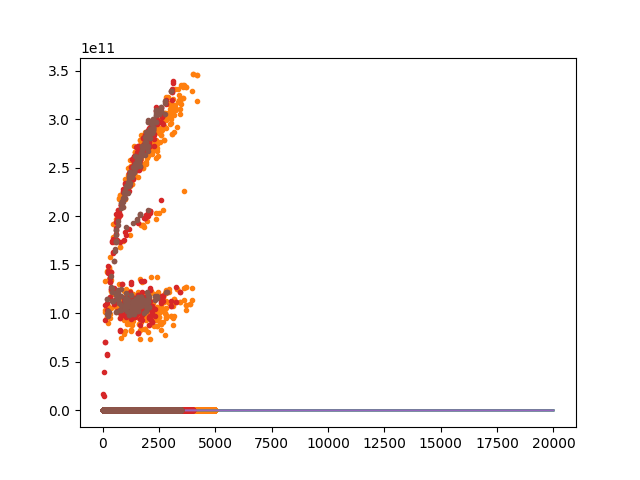

In [15]:
fig, ax = plt.subplots()

for ind, rate in enumerate(rates[3:6]):
    empty = {}

    ## Reading file and dump data into dict
    fname = './empty_data/empty_rate'+str(rate)+'.h5'
    with h5py.File(fname, 'r') as f:
        keys = f['data'].keys()
        for key in keys:
            empty[key] = f['data'][key][:]

    ## Reading calibration coeffs and ramp params
    thtr0 = calibration.thtr0
    thtr1 = calibration.thtr1
    thtr2 = calibration.thtr2
    heating_time = (temp1-temp0)*1000/rate
    isoBeginIdx = np.abs(empty['time'] - int(100+heating_time)).argmin() 
    isoEndIdx = np.abs(empty['time'] - int(300+heating_time)).argmin()
        
    empty_Rg = -0.5*thtr1/thtr2 - np.sqrt((thtr1**2-4*thtr2*(thtr0-empty['Thtr']))/4/thtr2**2)
    empty_P = empty['Uref']**2/empty_Rg

    empty_G = np.array([None for i in range(isoBeginIdx)], dtype=np.float32)
    empty_GdT = np.array([None for i in range(isoBeginIdx)], dtype=np.float32)
    empty_G_temp = np.linspace(empty['temp'][0], empty['temp'][isoBeginIdx], isoBeginIdx)

    empty_temp_heating = np.array([9999.0 for i in range(len(empty['temp']))])
    empty_temp_heating[:isoBeginIdx] = empty['temp'][:isoBeginIdx]
    empty_temp_cooling = np.array([9999.0 for i in range(len(empty['temp']))])
    empty_temp_cooling[isoEndIdx:] = empty['temp'][isoEndIdx:]
    ax.plot(empty_temp_heating)

    empty['rate'] = np.gradient(empty['temp'], empty['time'][1]-empty['time'][0])
        
    for i in range(len(empty_G_temp)):
        pos1 = (np.abs(empty_temp_heating - empty_G_temp[i]).argmin())
        pos2 = (np.abs(empty_temp_cooling - empty_G_temp[i]).argmin())
        empty_GdT[i] = (abs(empty['rate'][pos2])/(abs(empty['rate'][pos1])+abs(empty['rate'][pos2])))*\
                        abs(empty_P[pos1]-empty_P[pos2])+empty_P[pos2]
        empty_G[i] = empty_GdT[i]/(empty_G_temp[i]-empty_G_temp[0])
    empty_G[0]=0
    ax.plot(empty_G, '.')

plt.show()



In [6]:
device.disconnect()